In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
%matplotlib inline

In [58]:
# Read Images
img1, img2, img3 = cv2.imread("../data/nevada3.jpg"), cv2.imread("../data/nevada4.jpg"), cv2.imread("../data/nevada5.jpg")

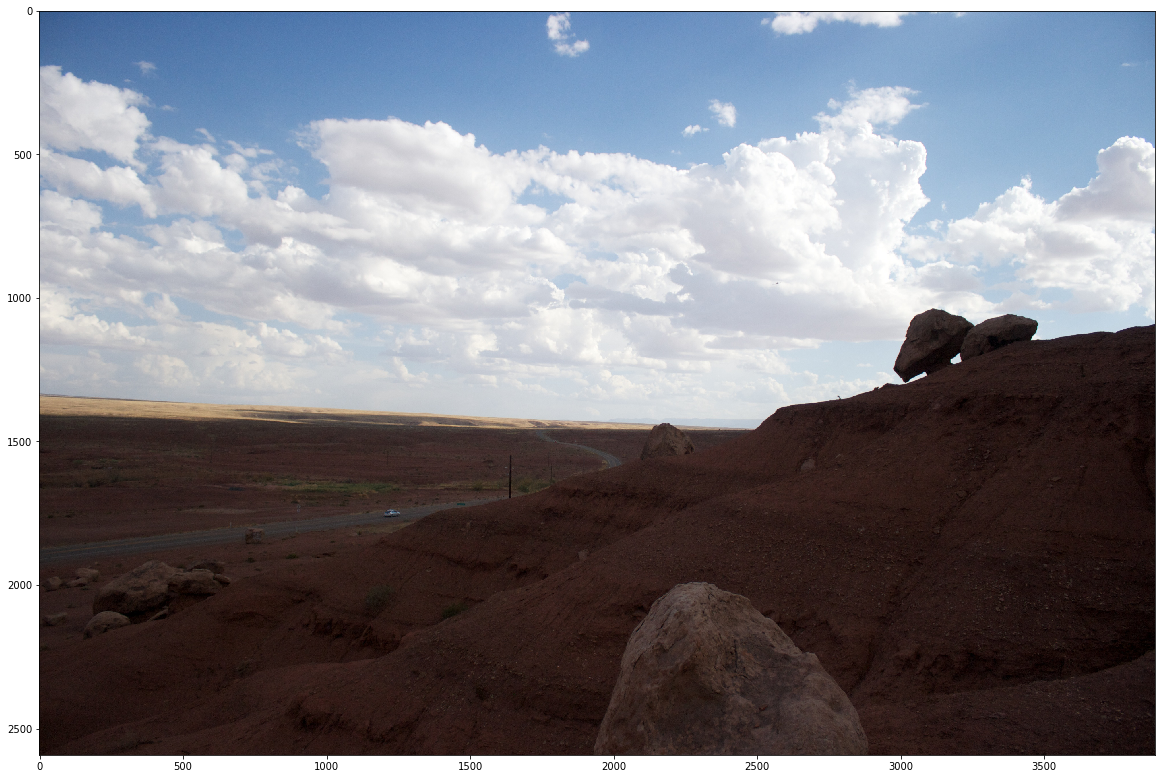

In [59]:
# Sanity Check
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

In [60]:
sift = cv2.xfeatures2d.SIFT_create()

In [61]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
kp3, des3 = sift.detectAndCompute(img3, None)

In [62]:
def plot_key_points(img, keypoints):
    """
    Input - 
            img - Source image
            keypoints - Keypoints of above image
    Returns - None
    
    Plot image by convert to color.
    """
    image_to_plot = cv2.drawKeypoints(img, keypoints, np.array([]))
    plt.rcParams["figure.figsize"] = [20, 20]
    plt.imshow(cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB))

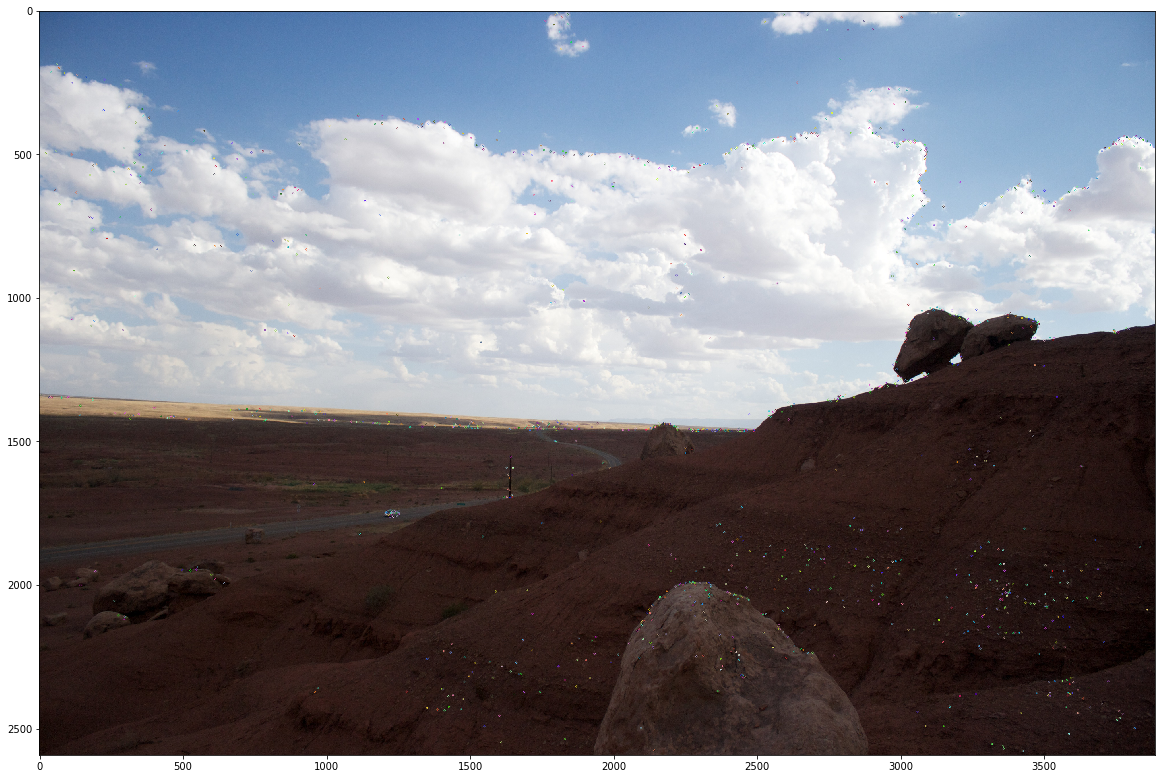

In [63]:
plot_key_points(img1, kp1)

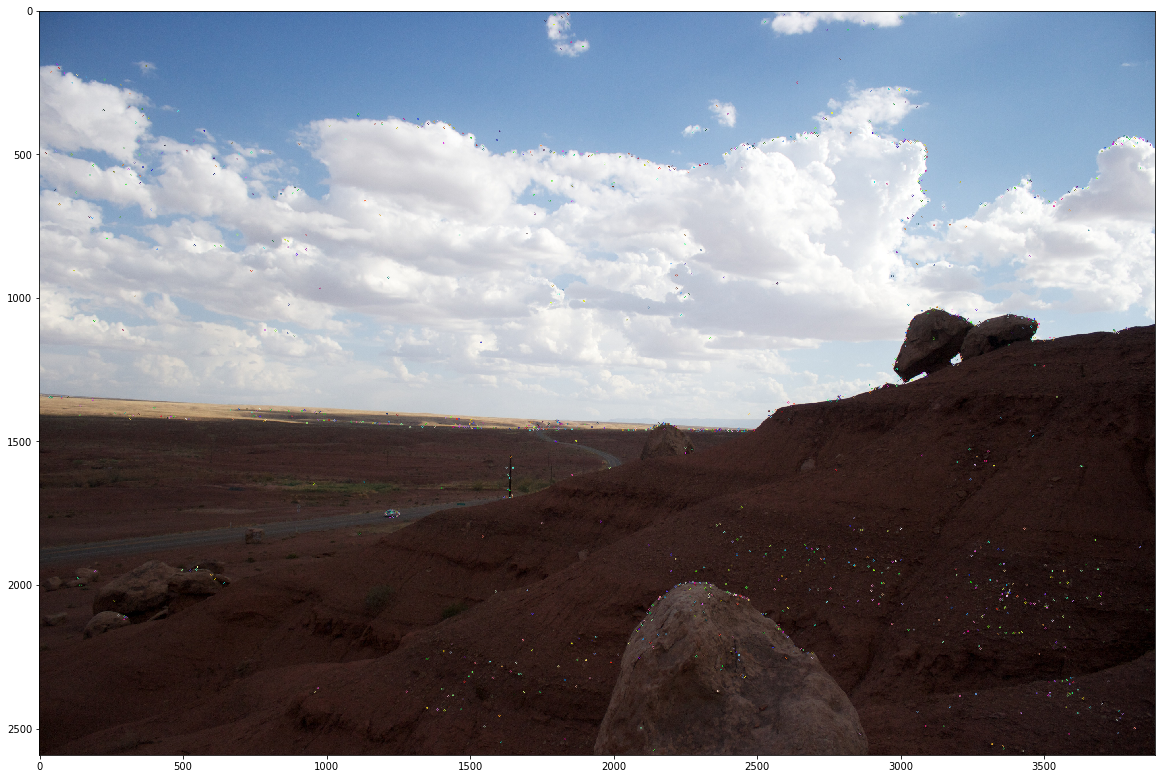

In [64]:
plot_key_points(img2, kp2)

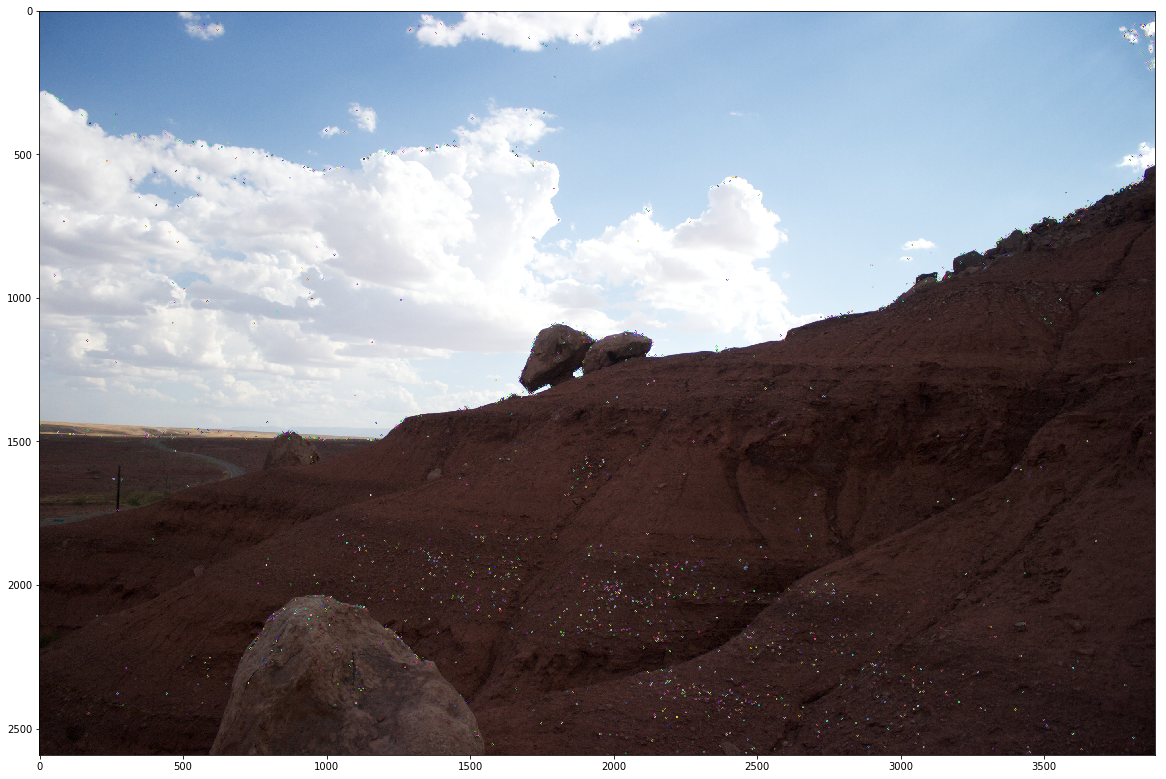

In [65]:
plot_key_points(img3, kp3)

In [66]:
def get_homography(point_group_1, point_group_2, verbose=False):
    """
    Input - 2 groups of points chosen randomly
             as a part of RANSAC
    Returns - Homography matrix
    """
    
    # Init P as None
    P = None
    
    # P matrix
    for point1, point2 in zip(point_group_1, point_group_2):
        # Get x, y & x', y'
        x, y = point1[0], point1[1]
        x_bar, y_bar = point2[0], point2[1]
        
        point_matrix = [
            [x, y, 1, 0, 0, 0, -x * x_bar, -y * x_bar, -x_bar],
            [0, 0, 0, x, y, 1, -x * y_bar, -y * y_bar, -y_bar]
        ]
        # If this is the first pair of rows
        if P is None:
            P = np.array(point_matrix)
        # Or stack to exitsting
        else:
            P = np.vstack((P, point_matrix))
    
    # Get eigenvalues & eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(P.T.dot(P))
    
    # Get minimum eigenvalue's index
    min_eigenvalue_index = np.argmin(eigenvalues)
    
    # Sanity check - 1
    if verbose:
        print("Minimum eigenvalue found at ", min_eigenvalue_index, ":", eigenvalues[min_eigenvalue_index])
    
    # Get corresponding eigenvector
    min_eigenvector = eigenvectors[:, min_eigenvalue_index]
    
    # Normalize the eigenvector by L2 norm
    norm = np.linalg.norm(min_eigenvector)
    min_eigenvector /= norm
    
    # Sanity check - 2 
    # These values must be close to 0
    if verbose:
        print ("These values should be close to 0", np.round(P.dot(min_eigenvector), 2))
    
    # Homography matrix
    H = min_eigenvector.reshape(3, 3)
    
    # Sanity check - 3
    for i, point in enumerate(point_group_1):
        point = [point[0], point[1], 1]
        point_2_predicted = np.dot(H, point)
        point_2_predicted = (point_2_predicted / point_2_predicted[-1])[:2]
        if verbose:
            print("Original point:", point[:-1])
            print("Predicted point:", point_2_predicted)
            print("Actual point:", point_group_2[i])
            print()
    
    return H

In [67]:
point_group_1 = [[100, 500], [31, 18], [15, 6]]
point_group_2 = [[10, 20], [20, 50], [10, 90]]

get_homography(point_group_1, point_group_2)

array([[-0.15959955,  0.42287866, -0.04314394],
       [-0.27423201,  0.83660115, -0.00491378],
       [-0.02536449,  0.04390606,  0.1270445 ]])

In [115]:
# Matcher - based on descriptors
def one_NN_matcher(des1, des2):
    """
    Input - 
            des1 & des2 - Descriptor matrices for 2 images
            k - Number of nearest neighbors to consider
    Returns - A vector of nearest neighbors of des1 & their indices for keypoints
    
    Mnemonic - des1 is like xtest, des2 is like xtrain
    """

    # Compute the L2 equations
    distances = np.sum(des1 ** 2, axis=1, keepdims=True) + np.sum(des2 ** 2, axis=1) - 2 * des1.dot(des2.T)
    distances = np.sqrt(distances)
    
    print(distances.shape)
    
    # Get smallest indices 
    min_indices = np.argmin(distances, axis=1)
    
    # Init ndarray 
    nearest_neighbors = np.zeros_like(min_indices, dtype=np.float32)
    
    # Iter for nearest neighbors
    for i in range(min_indices.shape[0]):
        nearest_neighbors[i] = des2[min_indices[i]]
    
    return min_indices, nearest_neighbors
    

In [116]:
one_NN_matcher(des2, des3)

(1503, 1989)


ValueError: setting an array element with a sequence.